# Set up the Google Colab notebook's environment (run this first!):

In [1]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo apt install python3-pip libfftw3-dev libgsl-dev
!pip install numpy scipy matplotlib lisa-data-challenge chainconsumer eryn astropy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-long3 libfftw3-quad3 libfftw3-single3 libgsl23
  libgslcblas0 python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  libfftw3-doc gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
  python-setuptools-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-long3 libfftw3-quad3 libfftw3-single3
  libgsl-dev libgsl23 libgslcblas0 python-pip-whl python3-pip
  python3-setuptools python3-wheel
0 upgraded, 12 newly installed, 0 to remove and 13 not upgraded.
Need to get 8,373 kB of archives.
After this operation, 37.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu1 [313 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu1 [673 kB]
Get:3 http:/

# LISA Tutorial

This notebook shows how to :
- Create galactic binary waveforms using FastGB
- Create noise that resembles lisa noise
- Use an Eryn, M. ᓚᘏᗢs mcmc, to find the binary parameters.


First, we'll import the necessary libraries

In [203]:
#Boiler plate python libraries
import matplotlib.pyplot as plt
import numpy as np
#lisa data challenge stuff
import ldc
from ldc.waveform.fastGB import FastGB
from ldc.lisa.noise import AnalyticNoise
from ldc.lisa.orbits import Orbits
from ldc.common.series import TDI
# M. ᓚᘏᗢs mcmc
import eryn
from eryn.prior import uniform_dist, ProbDistContainer
# units from astropy
from astropy import units as u

## Data Generation

First, we'll create a source waveform using FastGB (included in the LISA Data Challenge tools)

In [204]:
# We will first create a source by specifying galactic binary parameters in a dictionary
src = {'Amplitude': 4.532253297280512e-23,
 'EclipticLatitude': -0.6089326756389446,
 'EclipticLongitude': 4.363864825569529,
 'Frequency': 0.010068091384645718,
 'FrequencyDerivative': 1.7937336822447453e-15,
 'Inclination': 0.6741257207267898,
 'InitialPhase': 5.4809303996782806,
 'Polarization': 0.43040349955174967}

# We will then specify the LISA constellation's orbits parameters (these are the same as the default)
orbits = Orbits.type(dict({'orbit_type':'analytic', 'nominal_arm_length':2.5e6*u.km,
                           "initial_position": 0*u.rad, "initial_rotation": 0*u.rad}))

# the delta t for data (in s)
dt = 10

# Then specify the time we have had lisa in space, in this case 3 months, to start
t_max = (int( (93*u.day).to(u.s) / u.s ) // dt) * dt


GB = FastGB(delta_t=dt, T=t_max, orbits=orbits)

Simulated LISA data is convenient to work with in the AET channels. Here we will generate the waveform in XYZ and convert it to AET

In [205]:
from ldc.waveform.waveform import HpHc
from ldc.lisa.projection import ProjectedStrain
from ldc.common.series import TDI, FrequencySeries, TimeSeries
import scipy

def get_sources_AET(srcs,t_max=t_max,dt=dt):
  for (i,src) in enumerate(srcs):
    # h+, hx
    GW = HpHc.type("debug", "GB", "TD_fdot"); GW.set_param(src)
    p = ProjectedStrain(orbits)
    yArm = p.arm_response(0, t_max, dt, [GW])

    X = TimeSeries(p.compute_tdi_x(np.arange(0, t_max, dt)), dt=dt, t0=0)
    Y = TimeSeries(p.compute_tdi_y(np.arange(0, t_max, dt)), dt=dt, t0=0)
    Z = TimeSeries(p.compute_tdi_z(np.arange(0, t_max, dt)), dt=dt, t0=0)
    # should do PSD instead
    if i == 0:
      Xt = X.copy(); Yt = Y.copy(); Zt = Z.copy();
    else:
      Xt += X; Yt += Y; Zt += Z;


  Xf = Xt.ts.fft()
  Yf = Yt.ts.fft()
  Zf = Zt.ts.fft()

  AET_data_fd = TDI(dict(zip(["X", "Y", "Z"], [Xf,Yf,Zf])))
  AET_data_fd.XYZ2AET()

  f = np.fft.rfftfreq(t_max//dt,dt)
  return f, AET_data_fd

In [206]:
f, AET_data_fd = get_sources_AET([src])

Let's look at the synthesized waveform:

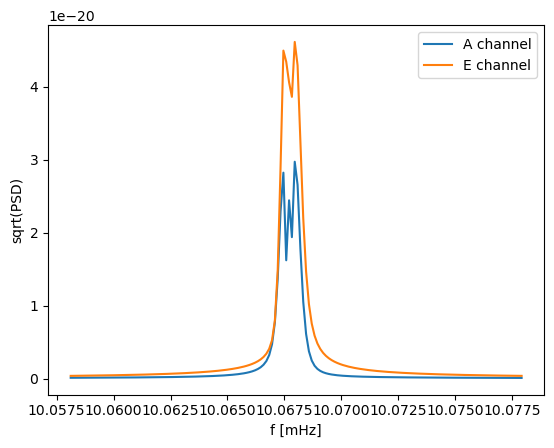

In [207]:
# choose a small window around the peak frequency
fmin = src["Frequency"]-1e-5
fmax = src["Frequency"]+1e-5
df = (AET_data_fd.f[1] - AET_data_fd.f[0]).to_numpy()
emin = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmin))
emax = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmax))
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.A[emin:emax])*np.sqrt(4*df),label='A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.E[emin:emax])*np.sqrt(4*df),label='E channel')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

## Noise Generation

Here we'll generate some noise matching the Sangria LDC.

If we know the theoretical noise PSD, we can make a realization of the noise with
$$
\text{FFT}_a = \sqrt{\frac{\text{PSD}_a}{2}} (x+ i y)
$$
where $x$ and $y$ are independent unit random normals, and $a$ labels the frequency.

/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in mult

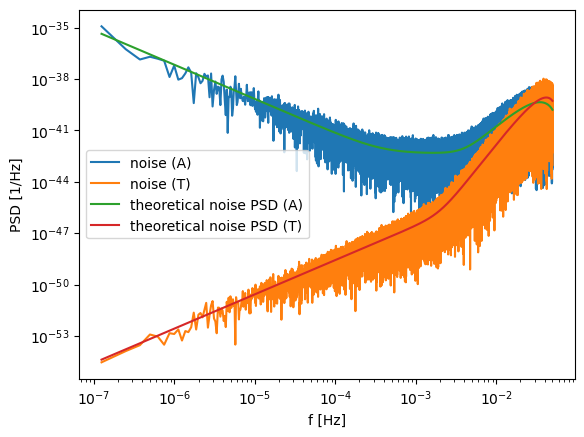

In [208]:
noise = AnalyticNoise(f,model="sangria")

# theoretical noise PSD
noise_psd_A = noise.psd(option='A',freq=f)
noise_psd_E = noise.psd(option='E',freq=f)
noise_psd_T = noise.psd(option='T',freq=f)

def randc(r):
    return r/np.sqrt(2)*(np.random.randn(*r.shape) + 1j*np.random.randn(*r.shape))

noise_fft = randc(np.sqrt(np.array([noise_psd_A,noise_psd_E,noise_psd_T])))


plt.loglog(f[f>0],np.abs(noise_fft[0][f>0])**2,label='noise (A)')
plt.loglog(f[f>0],np.abs(noise_fft[2][f>0])**2,label='noise (T)')
plt.loglog(f[f>0],noise_psd_A[f>0],label='theoretical noise PSD (A)')
plt.loglog(f[f>0],noise_psd_T[f>0],label='theoretical noise PSD (T)')
plt.ylabel("PSD [1/Hz]")
plt.xlabel("f [Hz]")
plt.legend()
plt.show()

The full data is now given by the noise plus our injection

In [209]:
data_A = AET_data_fd.A.to_numpy()*np.sqrt(4*df) + noise_fft[0]
data_E = AET_data_fd.E.to_numpy()*np.sqrt(4*df) + noise_fft[1]
data_T = AET_data_fd.T.to_numpy()*np.sqrt(4*df) + noise_fft[2]

In [210]:
s_a = noise.psd(freq=f, option='A')
snr_a = (4.0*df) * np.sum(np.abs(AET_data_fd.A)[:]**2/s_a)
print("Computed SNR is " + str(np.sqrt(float(snr_a))))

Computed SNR is 16.876517918589606


/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in mult

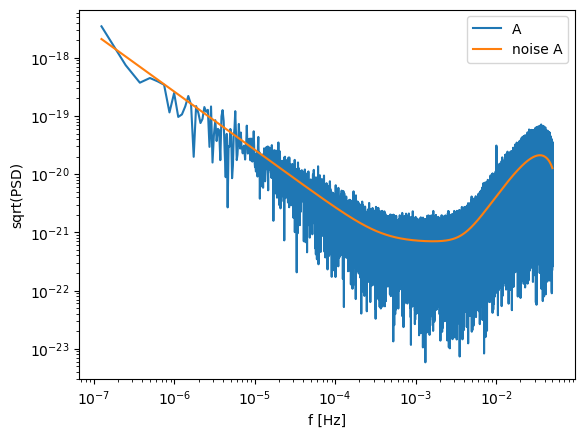

In [211]:
plt.loglog(f,np.abs(data_A),label='A')
plt.loglog(f,np.sqrt(noise.psd(freq=f, option='A')),label='noise A')
plt.ylabel("sqrt(PSD)")
plt.xlabel("f [Hz]")
plt.legend()
plt.show()

The GB signal is totally buried in the noise! But we can recover it

If we had done a periodogram on the data, the GB signal would be more visible, since a periodogram averages out noise

# Sampling

For the sampling, we will use an MCMC package called `eryn`.

You can read more about MCMCs in general and `eryn` in particular in the [`eryn` tutorial](https://github.com/mikekatz04/Eryn/blob/main/examples/Eryn_tutorial.ipynb).

Add more MCMC details here???

In [212]:
# log prior
fr_my_min = 3e-3
fr_my_max = 3e-2
priors = ProbDistContainer(
    {
        0: uniform_dist(-24.0,-20.0), # log10 amplitude
        1: uniform_dist(fr_my_min, fr_my_max),   ### fr in Hz
        2: uniform_dist(-17.0, -14.0),  ### log10 fdot
        3: uniform_dist(-1.0, 1.0), ###sin bet
        4: uniform_dist(0.0, 2.0*np.pi), ##lam
        5: uniform_dist(-1.0, 1.0), ## cos_iota
        6: uniform_dist(0.0, 2.0*np.pi), #psi
        7: uniform_dist(0.0, 2.0*np.pi), #phi0
    }
)

In [213]:
def as_gb_param(pp):
    """ switch from search parameterization to fastGB parameterization
    """
    l_Amp, mf0, l_fdot, sin_bet, lam, cos_iota, psi, phi0 = pp
    iota = np.arccos(cos_iota)
    beta = np.arcsin(sin_bet)
    amp = 10.0**l_Amp
    f0 = mf0
    fdot = 10.0**l_fdot
    return {'Frequency':f0, 'FrequencyDerivative':fdot, 'EclipticLatitude':beta, 'EclipticLongitude':lam,
            'Amplitude':amp, 'Inclination':iota, 'Polarization':psi, 'InitialPhase':phi0}

Next we'll define the Likelihood:

In [214]:
def likelihood(pars,Nsrc=1,data=[data_A,data_E,data_T],GB=GB,plotIt=False,noise=noise):
    """ pars is Nsrc x ndim
    """
    pars.shape= (Nsrc,len(pars)//Nsrc)
    # components of the likelihood
    start = 0
    stop = 0
    for ind in range(Nsrc):
        pp = pars[ind, :]
        pGB = as_gb_param(pp)
        if ind == 0:
            Xf, Yf, Zf = GB.get_fd_tdixyz(template=pGB, oversample=4)
            kmin = int(Xf.attrs["kmin"])
            start = kmin
            stop = kmin + len(Xf.f.values)
            df = (Xf.f[1]-Xf.f[0]).values
            Xdata = Xf.to_numpy()
            Ydata = Yf.to_numpy()
            Zdata = Zf.to_numpy()
            AETf = Xf.f.to_numpy()
        else:
            # if you have more than two sources, would need to update this likelihood a little bit
            Xf, Yf, Zf = GB.get_fd_tdixyz(template=pGB, oversample=4)
            kmin = int(Xf.attrs["kmin"])
            if kmin < start:
                lenXf = len(Xf.f.values)
                Xdata = np.hstack([np.zeros((start-kmin)), Xdata])
                Ydata = np.hstack([np.zeros((start-kmin)), Ydata])
                Zdata = np.hstack([np.zeros((start-kmin)), Zdata])
                Xdata[:lenXf] += Xf.to_numpy()
                Ydata[:lenXf] += Yf.to_numpy()
                Zdata[:lenXf] += Zf.to_numpy()
                AETf = np.hstack([Xf.f.to_numpy()[:start-kmin],AETf])
                start = kmin
            elif kmin > start:
                lenXf = len(Xf.f.values)
                Xdata = np.hstack([Xdata,np.zeros(kmin+lenXf - stop)])
                Ydata = np.hstack([Ydata,np.zeros(kmin+lenXf - stop)])
                Zdata = np.hstack([Zdata,np.zeros(kmin+lenXf - stop)])
                Xdata[kmin-start:] += Xf.to_numpy()
                Ydata[kmin-start:] += Yf.to_numpy()
                Zdata[kmin-start:] += Zf.to_numpy()
                AETf = np.hstack([Xf.f.to_numpy()[:kmin+lenXf - stop],AETf])
                stop = kmin+lenXf
            else:
                Xdata += Xf.to_numpy()
                Ydata += Yf.to_numpy()
                Zdata += Zf.to_numpy()
                
    SA = noise.psd(freq=AETf, option='A')
    At = data[0][start:stop]
    Et = data[1][start:stop]
    AET_A = (-Xdata + Zdata)*np.sqrt(4*df) / np.sqrt(2)
    AET_E = (Xdata - 2*Ydata + Zdata)*np.sqrt(4*df) / np.sqrt(6)
    SNR2 = np.sum( np.real(At * np.conjugate(AET_A) +\
                       Et * np.conjugate(AET_E)) /SA )
    hh = np.sum((np.absolute(AET_A)**2 + np.absolute(AET_E)**2) /SA)

    if plotIt:
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(16,8))
        ax[0].plot(AETf, np.abs(At), label='data')
        ax[0].plot(AETf, np.abs(AET_A), label='model',linestyle='--')
        ax[0].plot(AETf,np.sqrt(SA),label="noise",linestyle='--')
        
        ax[1].plot(AETf, np.abs(Et), label='data')
        ax[1].plot(AETf, np.abs(AET_E), label='model',linestyle='--')

        #ax[1].loglog(f,noise_psd_A)
        ax[1].plot(AETf,np.sqrt(SA),label="noise",linestyle='--')
        for i in range(2):
            ax[i].set_xlim([min(AETf), max(AETf)])
        #    ax[i].set_ylim([1.e-42, 1.5e-37])
        #    ax[i].legend();
        plt.show()
        #print(aaaa)

    loglik = ( SNR2 - 0.5 * hh )
    return loglik

In [215]:
inj=np.array([np.log10(src['Amplitude']),
            src['Frequency'], 
            np.log10(src['FrequencyDerivative']),
            np.sin(src['EclipticLatitude']),
            src['EclipticLongitude'],
            np.cos(src['Inclination']),
            src['Polarization'],
            src['InitialPhase']])
likelihood(inj.copy())

592.2566768944653

In [21]:
from eryn.ensemble import EnsembleSampler
ndim = len(src)
nwalkers=3*ndim
ntemps = 5
nchainlength= 10000
nburn=500

download_results = True

if not download_results:
  theta0 = np.array([[np.random.randn(ndim)*1e-8 + inj for _ in range(nwalkers)] for _ in range(ntemps)])

  print(inj)
  print(theta0.shape)
  import multiprocessing
  with multiprocessing.get_context('fork').Pool(multiprocessing.cpu_count()) as pool:
      sampler = EnsembleSampler(nwalkers,ndim,likelihood,priors,tempering_kwargs={'ntemps':ntemps},pool=pool)
      sampler.run_mcmc(theta0,nchainlength,progress=True,burn=nburn,tune=True,thin_by=1)
      tau=sampler.get_autocorr_time()['model_0']
      print(tau)
      # thin chains to make sure we have independent samples
      chains = sampler.get_chain(discard=int(np.ceil(3*np.max(tau))),thin=int(np.ceil(np.min(tau)/2)))['model_0']
      np.save("./chains11.npy",chains)
else:
  !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y" -O chains11.npy
  chains = np.load("./chains11.npy")

--2023-06-26 16:33:19--  https://drive.google.com/uc?export=download&id=1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y
Resolving drive.google.com (drive.google.com)... 64.233.182.138, 64.233.182.139, 64.233.182.102, ...
Connecting to drive.google.com (drive.google.com)|64.233.182.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/slsoen9uohl2skmqob4hl92e21js6qca/1687797150000/05374547873163544695/*/1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y?e=download&uuid=9b7e3efa-b3d2-4c79-af71-3b83d6ccd362 [following]
--2023-06-26 16:33:22--  https://doc-00-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/slsoen9uohl2skmqob4hl92e21js6qca/1687797150000/05374547873163544695/*/1-RksW-M9Nqut0NQzwmmWhN6KW1Dn6N2Y?e=download&uuid=9b7e3efa-b3d2-4c79-af71-3b83d6ccd362
Resolving doc-00-18-docs.googleusercontent.com (doc-00-18-docs.googleusercontent.com)... 172.253.119.132, 2607

The autocorrelation times (last line) measure how well our sampler is doing, and what percentage of samples we can keep

$\tau \rightarrow 1$ is best

In [22]:
chains_burnt=chains[:,0,:,:].reshape(chains.shape[0]*nwalkers,ndim)

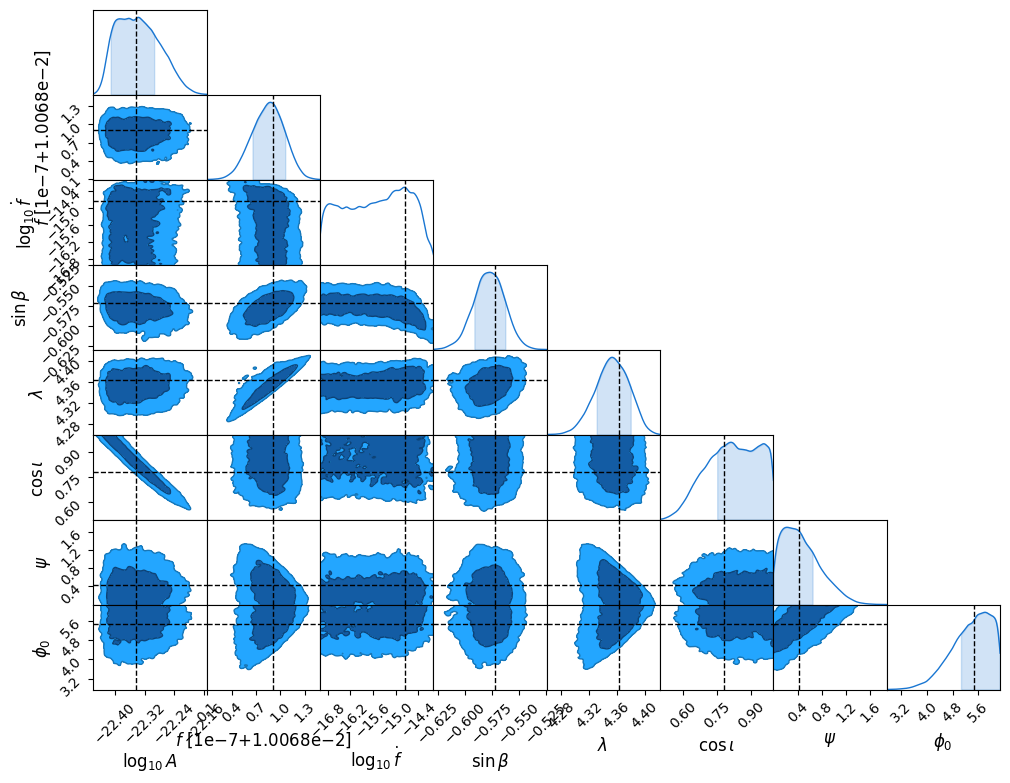

In [23]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
labels = [r'$\log_{10} A$',
          r'$f$',
          r'$\log_{10} \dot{f}$',
          r'$\sin \beta$',
          r'$\lambda$',
          r'$\cos \iota$',
          r'$\psi$',
          r'$\phi_{0}$']


truths = inj.flatten()
labels_final = labels
c.add_chain(chains_burnt,parameters=labels_final)
fig1 = c.plotter.plot(truth=truths, parameters = labels_final,figsize=(16*2/3,12*2/3))

We recovered the source!

### Diagnostic MCMC plots -- always important to check the path of the chains through parameter space!

This is what's called a trace plot. Here we're plotting the chains as a function of MCMC step for each parameter, and I'm coloring the cold chain as blue and hotter chains as increasingly more red as the temperature heats up.

Well-converged chains should look like the blue chains here, and rapidly oscillate around the extent of the posterior. If there is any kind of trend up or down, or the chains are frozen at particular values, your sampling is not converging!

Note also that the extent of the cold chains is nearly always contained within the extent of the hotter chains. This is exactly what we want when doing parallel tempering! See the `eryn` tutorial from Katz et al for more details.

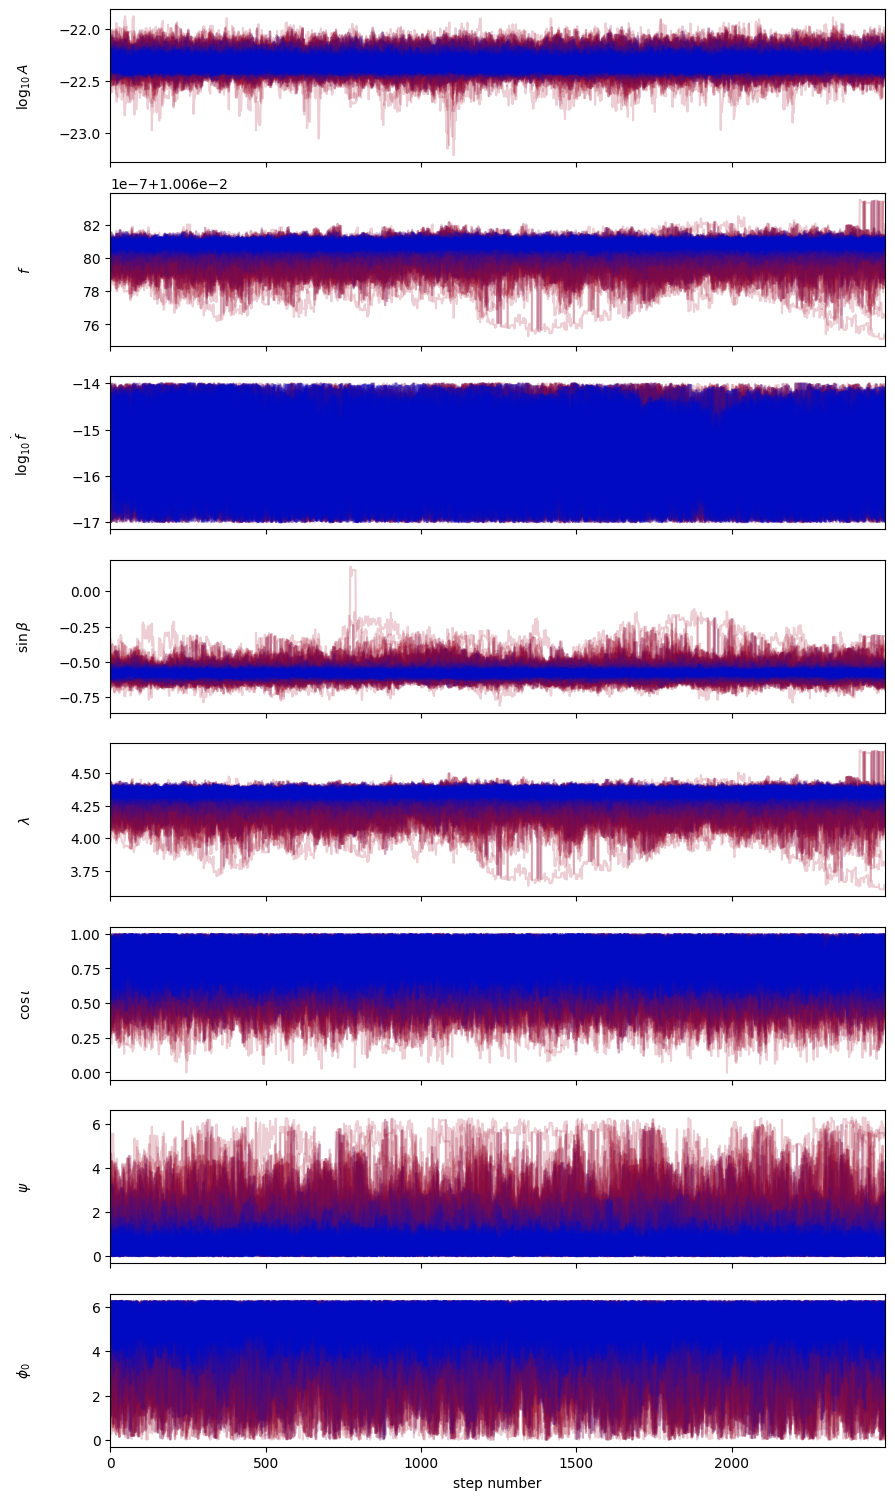

In [24]:
def color_interp(rgb_0,rgb_f,steps):
    r,g,b = rgb_0
    re,ge,be = rgb_f
    return ['#{:02X}{:02X}{:02X}'.format(int((re-r)/steps*i+r),int((ge-g)/steps*i+g),int((be-b)/steps*i+b)) for i in range(steps)]
ndim = chains.shape[-1]
fig, axes = plt.subplots(ndim, figsize=(10, 7/3*(ndim)), sharex=True)
#keylist=list(priors.keys())
#labels = keylist
#ntemps = self.ntemps
#nwalkers = self.nwalkers
csteps = color_interp((0,10,200),(200,10,0),ntemps)
for j in range(ndim):
    ax = axes[j]
    ax.set_xlim(0, chains.shape[0])
    ax.set_ylabel(labels_final[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    for t in reversed(range(ntemps)):
        for k in range(nwalkers):
            ax.plot(chains[:,t,k,0,j],c=csteps[t],alpha=0.2)
#ll = sampler.get_log_like()
#for k in range(nwalkers):
#    axes[-1].plot(ll[:,0,k])
#axes[-1].set_ylabel("log pos (T=1)")
#axes[-1].yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

# Now let's try our own mini "global fit" with two sources

In [216]:
# the first source is the same as the last one
src1 = {'Amplitude': 4.532253297280512e-23,
 'EclipticLatitude': -0.6089326756389446,
 'EclipticLongitude': 4.363864825569529,
 'Frequency': 0.010068091384645718,
 'FrequencyDerivative': 1.7937336822447453e-15,
 'Inclination': 0.6741257207267898,
 'InitialPhase': 5.4809303996782806,
 'Polarization': 0.43040349955174967}
# the second will be similar, but in another location on the sky and with a few different parameters
src2 = src1.copy()
src2["EclipticLatitude"] += -np.pi/4
src2["EclipticLongitude"] = np.pi/4
src2["EclipticLongitude"] %= (2*np.pi)
src2["EclipticLatitude"]  %= (np.pi/2)
#src2["FrequencyDerivative"] = src1["FrequencyDerivative"]*1.5
#src2["Inclination"] = 0.3
#src2["Frequency"] += 0.0

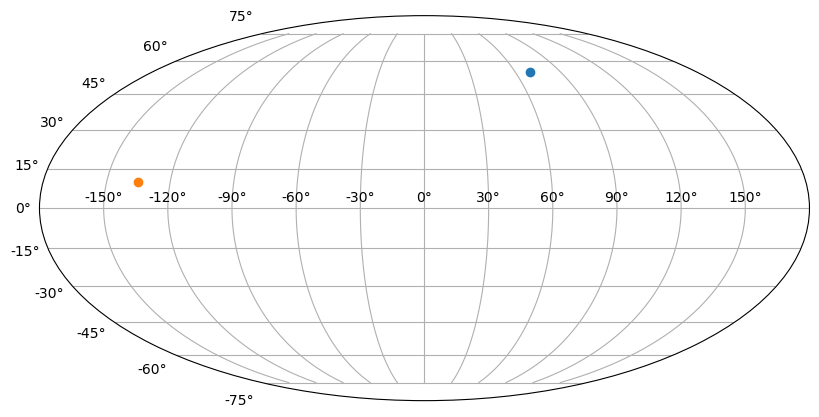

In [217]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(src1["EclipticLongitude"]-np.pi,src1["EclipticLatitude"]%(np.pi/2))
ax.scatter(src2["EclipticLongitude"]-np.pi,src2["EclipticLatitude"]%(np.pi/2))
plt.show()

## Generating the data

In [218]:
f, AET_data_fd = get_sources_AET([src1,src2])
f, AET_data_fd1 = get_sources_AET([src1])
f, AET_data_fd2 = get_sources_AET([src2])
df = f[1] - f[0]
data_A = AET_data_fd.A.to_numpy()*np.sqrt(4*df) + noise_fft[0]
data_E = AET_data_fd.E.to_numpy()*np.sqrt(4*df) + noise_fft[1]
data_T = AET_data_fd.T.to_numpy()*np.sqrt(4*df) + noise_fft[2]

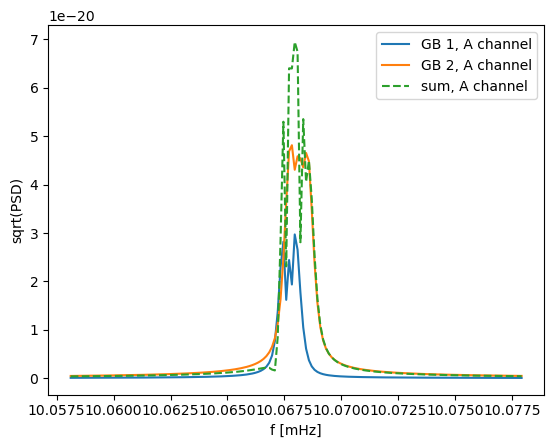

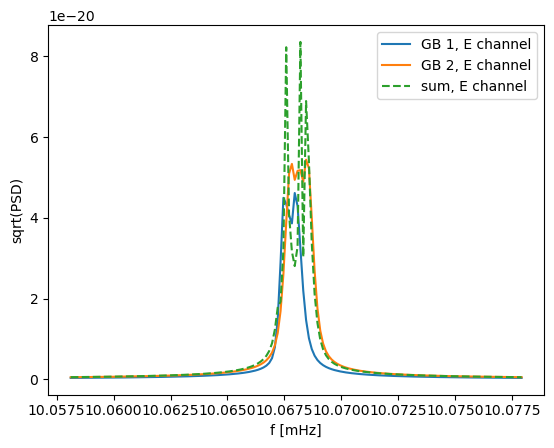

In [219]:
# choose a small window around the peak frequency
fmin = src1["Frequency"]-1e-5
fmax = src1["Frequency"]+1e-5
df = AET_data_fd.f[1] - AET_data_fd.f[0]
emin = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmin))
emax = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmax))
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.A[emin:emax])*np.sqrt(4*df),label='GB 1, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.A[emin:emax])*np.sqrt(4*df),label='GB 2, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.A[emin:emax])*np.sqrt(4*df),label='sum, A channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.E[emin:emax])*np.sqrt(4*df),label='GB 1, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.E[emin:emax])*np.sqrt(4*df),label='GB 2, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.E[emin:emax])*np.sqrt(4*df),label='sum, E channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

## Recovery as if we only had one source

In [225]:
inj = np.array([np.log10(src2['Amplitude']),
            src2['Frequency'],
            np.log10(src2['FrequencyDerivative']),
            np.sin(src2['EclipticLatitude']),
            src2['EclipticLongitude'],
            np.cos(src2['Inclination']),
            src2['Polarization'],
            src2['InitialPhase'],
               ])
likelihood(inj.copy(),Nsrc=1,data=[data_A,data_E,data_T],plotIt=False)

1206.8204821788236

In [226]:
from eryn.ensemble import EnsembleSampler
ndim = len(src)
nwalkers=3*ndim
ntemps = 5
nchainlength= 10000
nburn=500

download_results = True

if not download_results:
  theta0 = np.array([[np.random.randn(ndim)*1e-8 + inj for _ in range(nwalkers)] for _ in range(ntemps)])

  print(inj)
  print(theta0.shape)
  import multiprocessing
  with multiprocessing.get_context('fork').Pool(multiprocessing.cpu_count()) as pool:
      sampler = EnsembleSampler(nwalkers,ndim,likelihood,priors,tempering_kwargs={'ntemps':ntemps},pool=pool)
      sampler.run_mcmc(theta0,nchainlength,progress=True,burn=nburn,tune=True,thin_by=1)
      tau=sampler.get_autocorr_time()['model_0']
      print(tau)
      # thin chains to make sure we have independent samples
      chains = sampler.get_chain(discard=int(np.ceil(3*np.max(tau))),thin=int(np.ceil(np.min(tau)/2)))['model_0']
      np.save("./chains3_21.npy",chains)
else:
  !wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1hpcCbFDlGotfLTXBAWl78Ptf80p_cBoH" -O chains3_21.npy
  chains = np.load("./chains3_21.npy")

[-2.23436858e+01  1.00680914e-02 -1.47462420e+01  1.75551055e-01
  7.85398163e-01  7.81252987e-01  4.30403500e-01  5.48093040e+00]
(5, 24, 8)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:22<00:00, 49.45it/s]


[[23.50692467  9.26330848 10.92118864  9.04735469 12.57461682 11.59252789
  12.52367564 14.15563497]]


In [227]:
chains_burnt=chains[:,0,:,:].reshape(chains.shape[0]*nwalkers,ndim)

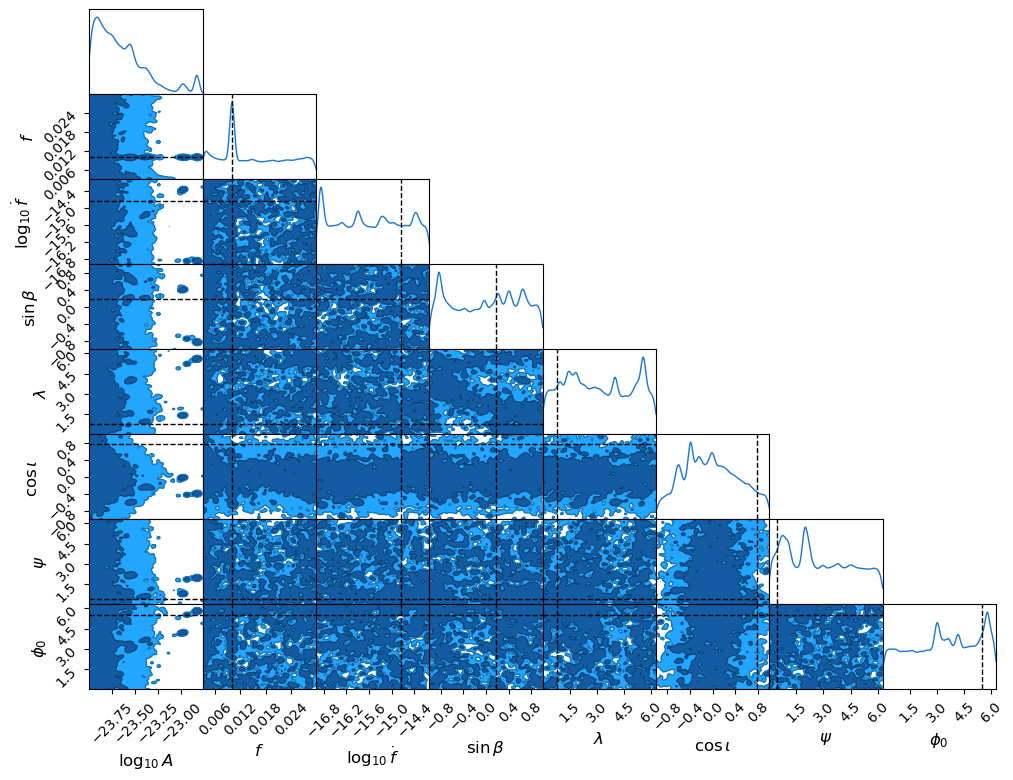

In [228]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
labels = [r'$\log_{10} A$',
          r'$f$',
          r'$\log_{10} \dot{f}$',
          r'$\sin \beta$',
          r'$\lambda$',
          r'$\cos \iota$',
          r'$\psi$',
          r'$\phi_{0}$']


truths = inj.flatten()
labels_final = labels
c.add_chain(chains_burnt,parameters=labels_final)
fig1 = c.plotter.plot(truth=truths, parameters = labels_final,figsize=(16*2/3,12*2/3))

Here the lines are comparing to the second injection, but they're pretty far off of either one!

## Recovery as two sources

In [179]:
inj2 = np.array([np.log10(src1['Amplitude']),
            src1['Frequency'],
            np.log10(src1['FrequencyDerivative']),
            np.sin(src1['EclipticLatitude']),
            src1['EclipticLongitude'],
            np.cos(src1['Inclination']),
            src1['Polarization'],
            src1['InitialPhase'],
            np.log10(src2['Amplitude']),
            src2['Frequency'],
            np.log10(src2['FrequencyDerivative']),
            np.sin(src2['EclipticLatitude']),
            src2['EclipticLongitude'],
            np.cos(src2['Inclination']),
            src2['Polarization'],
            src2['InitialPhase']])
likelihood(inj2.copy(),Nsrc=2,data=[data_A,data_E,data_T],plotIt=False)

1836.8815394892085

In [180]:
fr_my_min = 3e-3
fr_my_max = 3e-2
priors = ProbDistContainer(
    {
        0: uniform_dist(-24.0,-20.0), # log10 amplitude
        1: uniform_dist(fr_my_min, fr_my_max),   ### fr in Hz
        2: uniform_dist(-17.0, -14.0),  ### log10 fdot
        3: uniform_dist(-1.0, 1.0), ###sin bet
        4: uniform_dist(0.0, 2.0*np.pi), ##lam
        5: uniform_dist(-1.0, 1.0), ## cos_iota
        6: uniform_dist(0.0, 2.0*np.pi), #psi
        7: uniform_dist(0.0, 2.0*np.pi), #phi0
        8: uniform_dist(-24.0,-20.0), # log10 amplitude
        9: uniform_dist(fr_my_min, fr_my_max),   ### fr in Hz
        10: uniform_dist(-17.0, -14.0),  ### log10 fdot
        11: uniform_dist(-1.0, 1.0), ###sin bet
        12: uniform_dist(0.0, 2.0*np.pi), ##lam
        13: uniform_dist(-1.0, 1.0), ## cos_iota
        14: uniform_dist(0.0, 2.0*np.pi), #psi
        15: uniform_dist(0.0, 2.0*np.pi), #phi0
    }
)

In [181]:
from eryn.ensemble import EnsembleSampler
ndim = len(inj2)
nwalkers=3*ndim
ntemps = 5
nchainlength= 10000
nburn=500

# start in a small ball around the right answer
# to initialize blind searches, could use a peak detection
theta0 = np.array([[np.random.randn(ndim)*1e-8 + inj2 for _ in range(nwalkers)] for _ in range(ntemps)])
download_results = True

if not download_results:
  import multiprocessing
  with multiprocessing.get_context('fork').Pool(multiprocessing.cpu_count()) as pool:
      sampler = EnsembleSampler(nwalkers,ndim,likelihood,priors,tempering_kwargs={'ntemps':ntemps},pool=pool,args=(2,))
      sampler.run_mcmc(theta0,nchainlength,progress=True,burn=nburn,tune=True,thin_by=1)
  tau=sampler.get_autocorr_time()['model_0']
  print(tau)
  # thin chains to make sure we have independent samples
  chains = sampler.get_chain(discard=int(np.ceil(3*np.max(tau))),thin=int(np.ceil(np.min(tau)/2)))['model_0']
  np.save("./chains3_22.npy",chains)
else:
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cVqo7RI7ihNXFMoeEkC--6VxtuGFMtrt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1cVqo7RI7ihNXFMoeEkC--6VxtuGFMtrt" -O chains3_22.npy && rm -rf /tmp/cookies.txt
  chains = np.load("./chains3_22.npy")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:08<00:00, 23.36it/s]


[[ 7.74661557  8.26767721 12.97712968  7.15231949  7.72683227  7.98110434
   7.60183392  7.42368856  8.85757769  8.42416278 20.53256651  7.57255195
   7.50043703  9.28090931  6.71892143  7.61900042]]


In [182]:
chains_burnt = chains[:,0,:,:].reshape(chains.shape[0]*nwalkers,ndim)

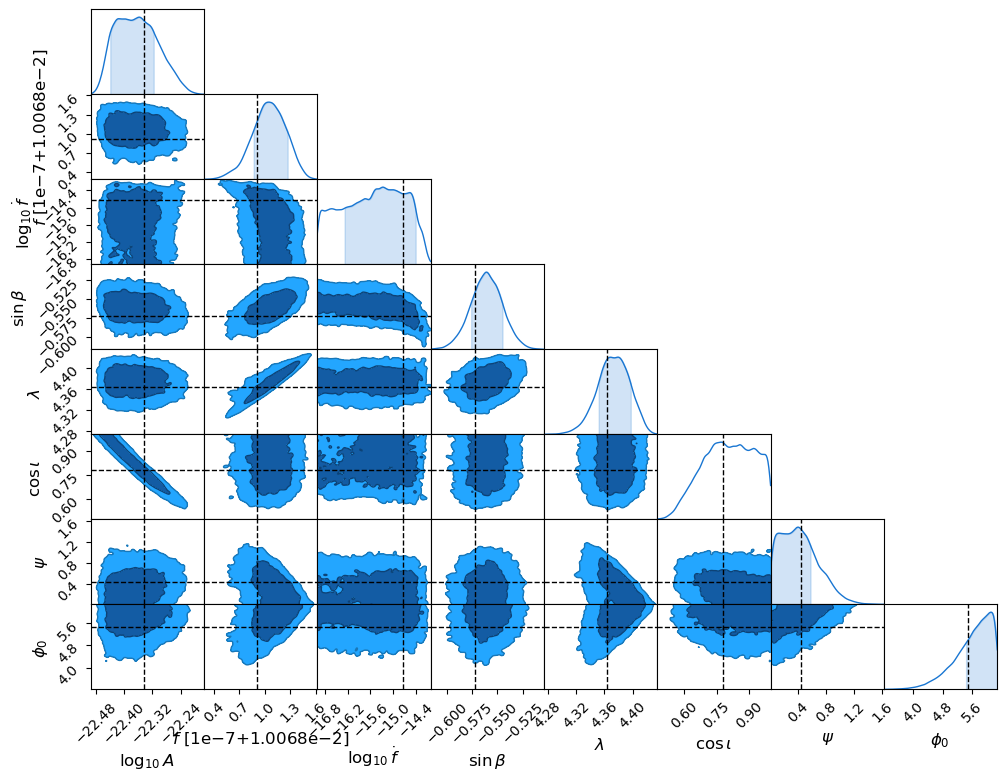

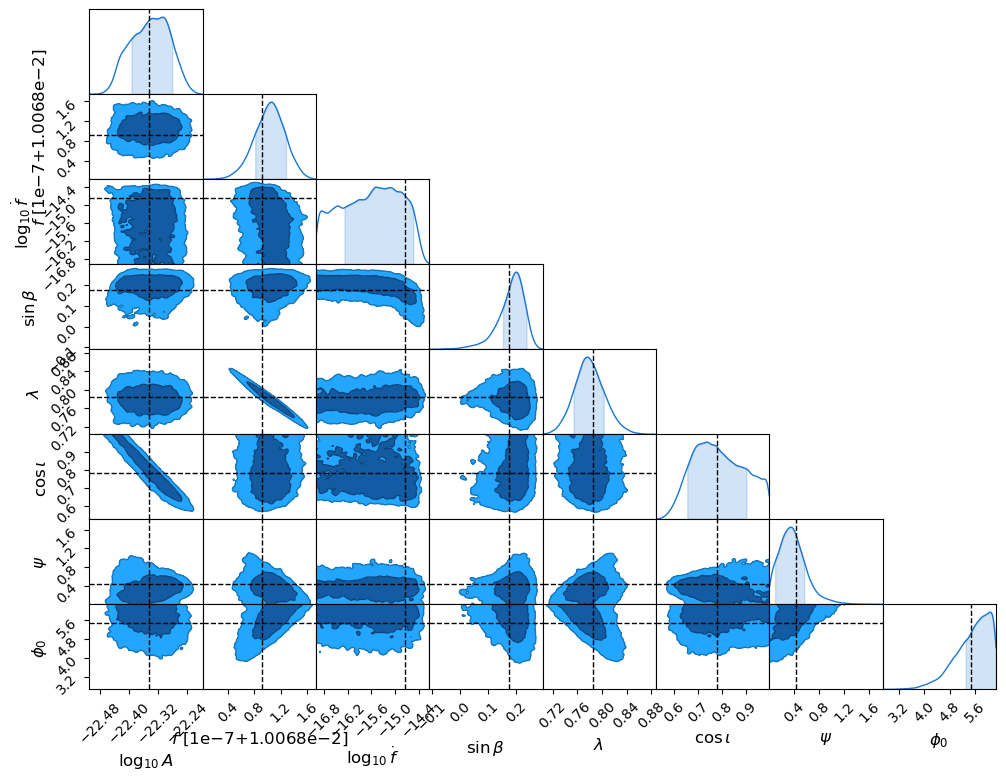

In [183]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
labels = [r'$\log_{10} A$',
          r'$f$',
          r'$\log_{10} \dot{f}$',
          r'$\sin \beta$',
          r'$\lambda$',
          r'$\cos \iota$',
          r'$\psi$',
          r'$\phi_{0}$']
truths = inj2
labels_final = labels
c.add_chain(chains_burnt[:,:8],parameters=labels_final,name='GB 1')
fig1 = c.plotter.plot(truth=truths[:8], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()
c = ChainConsumer()
c.add_chain(chains_burnt[:,8:],parameters=labels_final,name='GB 2')
fig2 = c.plotter.plot(truth=truths[8:], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()

# Retry two sources with more data!

In [184]:
dt = 10
t_max = (int( (365*u.day).to(u.s) / u.s ) // dt) * dt

GB = FastGB(delta_t=dt, T=t_max, orbits=orbits)

In [185]:
f, AET_data_fd = get_sources_AET([src1,src2],t_max=t_max,dt=dt)
f, AET_data_fd1 = get_sources_AET([src1],t_max=t_max,dt=dt)
f, AET_data_fd2 = get_sources_AET([src2],t_max=t_max,dt=dt)
df = f[1] - f[0]

# theoretical noise PSD
noise_psd_A = noise.psd(option='A',freq=f)
noise_psd_E = noise.psd(option='E',freq=f)
noise_psd_T = noise.psd(option='T',freq=f)

def randc(r):
    return r/np.sqrt(2)*(np.random.randn(*r.shape) + 1j*np.random.randn(*r.shape))

noise_fft = randc(np.sqrt(np.array([noise_psd_A,noise_psd_E,noise_psd_T])))


data_A = AET_data_fd.A.to_numpy()*np.sqrt(4*df) + noise_fft[0]
data_E = AET_data_fd.E.to_numpy()*np.sqrt(4*df) + noise_fft[1]
data_T = AET_data_fd.T.to_numpy()*np.sqrt(4*df) + noise_fft[2]

/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in mult

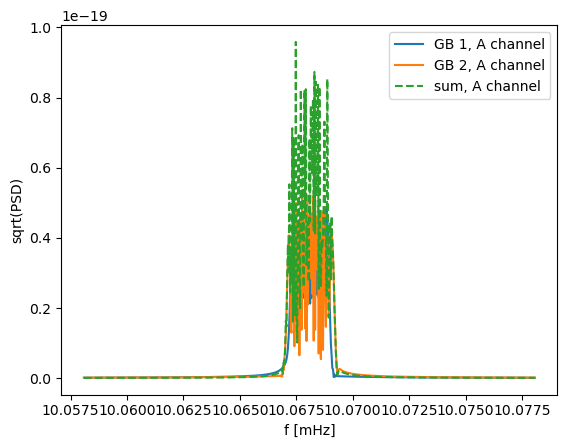

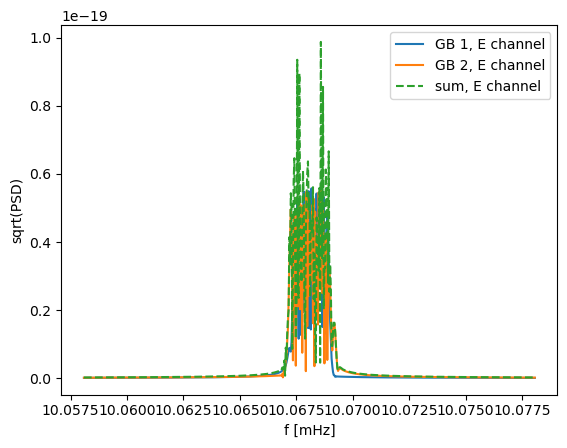

In [186]:
# choose a small window around the peak frequency
fmin = src1["Frequency"]-1e-5
fmax = src1["Frequency"]+1e-5
df = AET_data_fd.f[1] - AET_data_fd.f[0]
emin = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmin))
emax = np.argmin(np.abs(AET_data_fd.f.to_numpy()-fmax))
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.A[emin:emax])*np.sqrt(4*df),label='GB 1, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.A[emin:emax])*np.sqrt(4*df),label='GB 2, A channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.A[emin:emax])*np.sqrt(4*df),label='sum, A channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd1.E[emin:emax])*np.sqrt(4*df),label='GB 1, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd2.E[emin:emax])*np.sqrt(4*df),label='GB 2, E channel')
plt.plot(f[emin:emax]*1e3,np.abs(AET_data_fd.E[emin:emax])*np.sqrt(4*df),label='sum, E channel',ls='dashed')
plt.ylabel('sqrt(PSD)')
plt.xlabel('f [mHz]')
plt.legend()
plt.show()

In [187]:
s_a = noise.psd(freq=f, option='A')
snr_a = (4.0*df) * np.sum(np.abs(AET_data_fd.A)[:]**2/s_a)
print("Computed SNR is " + str(np.sqrt(float(snr_a))))

/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:288: RuntimeWarning: divide by zero encountered in divide
  sa_a = AnalyticNoise.psd_a_a[self.model] * (1.0 +(0.4e-3/frq)**2) *\
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:290: RuntimeWarning: divide by zero encountered in power
  self.sa_d = sa_a*(2.*np.pi*frq)**(-4.) # in displacement
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:291: RuntimeWarning: invalid value encountered in multiply
  sa_nu = self.sa_d*(2.0*np.pi*frq/CLIGHT)**2 # in rel freq unit
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:295: RuntimeWarning: divide by zero encountered in divide
  relax = (1. + (2.e-3/frq)**4) if self.oms_relaxation else 1.0
/Users/robbie/miniconda3/envs/lisa-tut/lib/python3.9/site-packages/ldc/lisa/noise/noise.py:297: RuntimeWarning: invalid value encountered in mult

Computed SNR is 101.71856381047249


In [188]:
likelihood(inj2.copy(),Nsrc=2,data=[data_A,data_E,data_T],GB=GB)

8920.356519143083

In [189]:
from eryn.ensemble import EnsembleSampler
ndim = len(inj2)
nwalkers=3*ndim
ntemps = 5
nchainlength= 15000
nburn=500

# start in a small ball around the right answer
# to initialize blind searches, could use a peak detection
theta0 = np.array([[np.random.randn(ndim)*1e-12 + inj2 for _ in range(nwalkers)] for _ in range(ntemps)])
download_results = True

if not download_results:
  import multiprocessing
  with multiprocessing.get_context('fork').Pool(multiprocessing.cpu_count()) as pool:
      sampler = EnsembleSampler(nwalkers,ndim,likelihood,priors,tempering_kwargs={'ntemps':ntemps},pool=pool,args=(2,))
      sampler.run_mcmc(theta0,nchainlength,progress=True,burn=nburn,tune=True,thin_by=1)
  tau=sampler.get_autocorr_time()['model_0']
  print(tau)
  # thin chains to make sure we have independent samples
  chains = sampler.get_chain(discard=int(np.ceil(3*np.max(tau))),thin=int(np.ceil(np.min(tau)/2)))['model_0']
  np.save("./chains12_22.npy",chains)
else:
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VDsIIPoVnTEXXYYHYysxFD8Y-G1oE0LR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VDsIIPoVnTEXXYYHYysxFD8Y-G1oE0LR" -O chains12_22.npy && rm -rf /tmp/cookies.txt
  chains = np.load("./chains12_22.npy")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [10:40<00:00, 23.43it/s]


[[ 7.62532705  7.55025292 18.802516    7.32474376  7.29761777  7.84518146
   7.4983593   7.43973415  8.04953478  7.13221557 17.6488685   6.94442536
   6.8975174   8.02173372  7.31935542  7.70468825]]


In [192]:
chains_burnt = chains[:,0,:,:].reshape(chains.shape[0]*nwalkers,ndim)

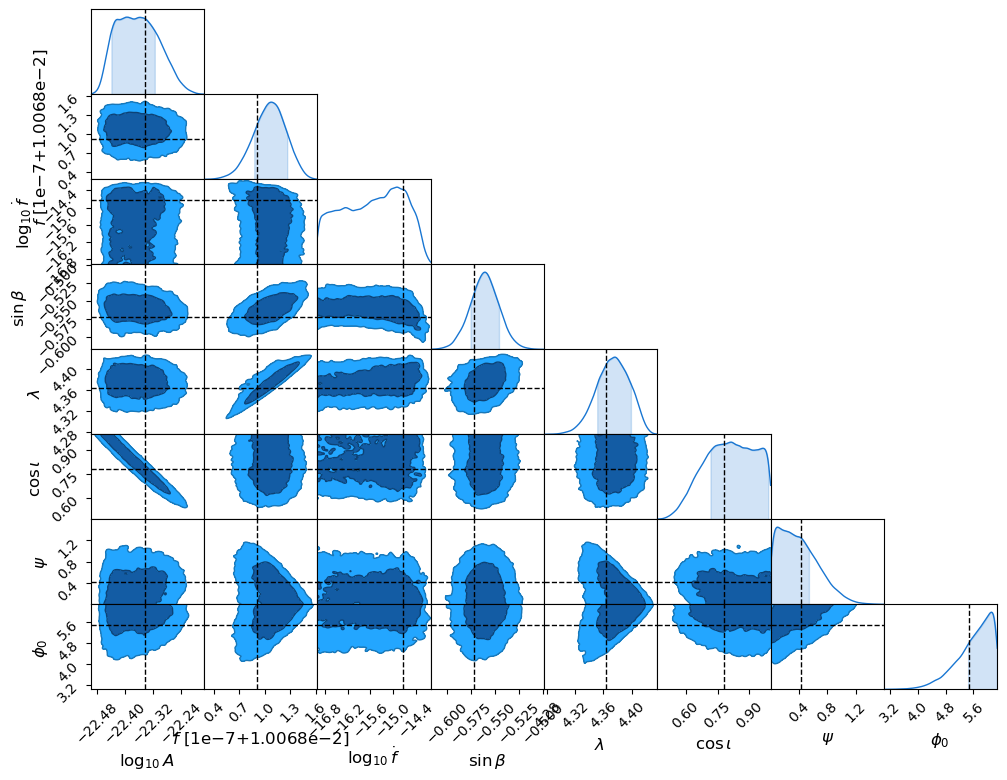

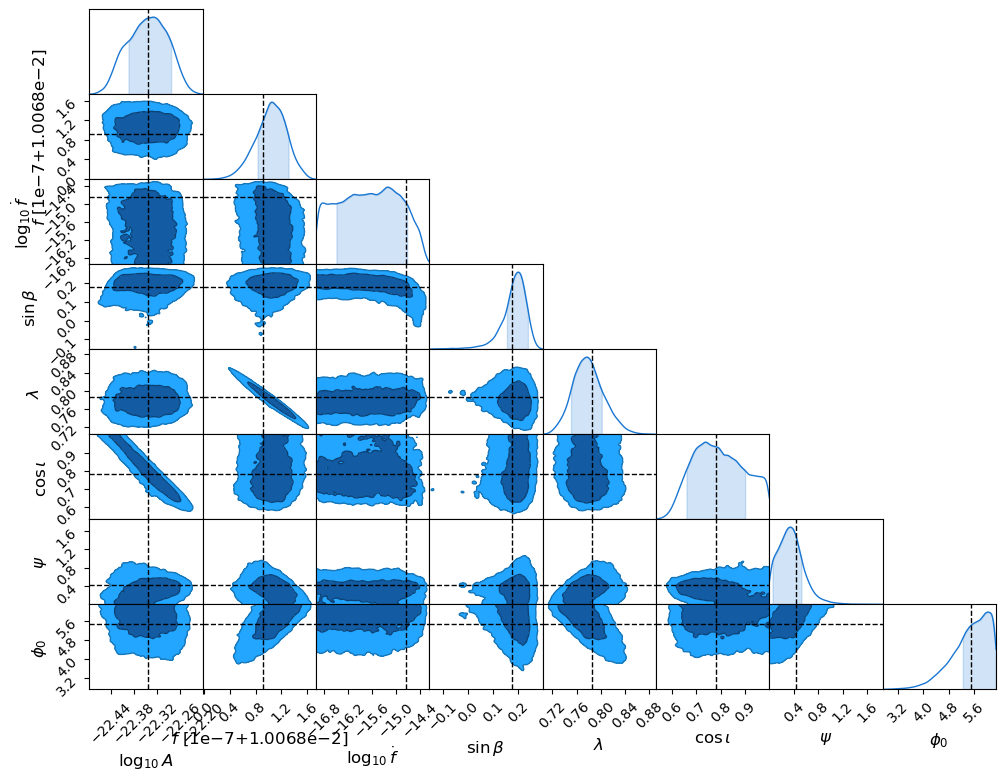

In [193]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
labels = [r'$\log_{10} A$',
          r'$f$',
          r'$\log_{10} \dot{f}$',
          r'$\sin \beta$',
          r'$\lambda$',
          r'$\cos \iota$',
          r'$\psi$',
          r'$\phi_{0}$']
truths = inj2
labels_final = labels
c.add_chain(chains_burnt[:,:8],parameters=labels_final,name='GB 1')
fig1 = c.plotter.plot(truth=truths[:8], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()
c = ChainConsumer()
c.add_chain(chains_burnt[:,8:],parameters=labels_final,name='GB 2')
fig2 = c.plotter.plot(truth=truths[8:], parameters = labels_final,figsize=(16*2/3,12*2/3))
plt.show()

# Next steps for understanding more LISA global fit data analysis
- [Tyson Littenberg's and Neil Cornish's Global Fit pipeline paper](https://arxiv.org/abs/2301.03673)
- Try playing with the [LISA data challenges](https://lisa-ldc.lal.in2p3.fr/) and working through their tutorials, it's free to sign up and you don't have to join LISA (but you should anyway)
- Check out talks from the last LISA symposium, all online [here](https://www.youtube.com/playlist?list=PLM05cB3oZeszWMRUuhuOz8GkBvQibPZlv).
- See [a talk from Robert Rosati](https://www.youtube.com/watch?v=FTLhmyALrnQ&list=PLM05cB3oZeszWMRUuhuOz8GkBvQibPZlv&index=94) about detecting primordial stochastic backgrounds from cosmology during the LISA global fit